In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

from time import time
from datetime import datetime
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import random

print(tf.__version__)


1.12.0


In [2]:
import platform
print(platform.python_version())

3.6.7


In [3]:
run_tag = "conv11"

EPOCHS = 3
size = 256   # of the "large" image emulating camera frame
size_th = 32 # 64 # 28 # of the scaled down "thumbnail" that is passed to tensorflow model, e.x. 28 

lane_width = 80 # width of the "road" in pixels on the large image

noise_circles = 5 # 5
noise_dots = 500 # 500

color_bg = (255,255,255,255)
color_fg = (0,0,0,255)
color_outline = (255,255,255,255)
color_fill = (255,255,255,127)

img_size = (size,size)
poly_size = (size,size)
poly_offset = (0,0) #location in base image
polygon = [ (0,0), (0,size), (size,size), (size,0) ]
line_width = 5 # of the elements in the large image

class_names = ['left', 'left-corr', 'straight', 'right-corr', 'right']

num_classes = len(class_names)

class_names_dictionary = {
        0:'left', 1:'left-corr', 2:'straight', 3:'right-corr', 4:'right'
    }


In [4]:
# makes one large RGBA image, simulating camera frame
def make_image (dir):
    mode = 'RGBA'
    back_img = Image.new(mode, img_size, color_bg)
    poly_img = Image.new(mode, poly_size)
    pdraw = ImageDraw.Draw(poly_img)
    pdraw.polygon(polygon, fill=color_fill, outline=color_outline)
    
    px = random.randint(1,100)
    py = random.randint(1,100)
    pxx = random.randint(-10,10)
    pyy = random.randint(1,100)
    pxmid = random.randint(120,132) # around the center point
    pymid = random.randint(120,132)
    dx = random.randint(20,100) # for left and right correction
    dy = 0

    # draw the two-line lane to be recognized:
    for i in range (-1, 1) :
        l_width = lane_width / 2 * i
        y_corr = l_width * 3 / 4
        if dir == 0 : # left
            pdraw.line((pxmid+l_width, pymid-y_corr, px+l_width, py-y_corr), fill=color_fg, width=line_width)
            pdraw.line((pxmid+l_width, pymid-y_corr, pxmid+l_width, size-5-pyy-y_corr), fill=color_fg, width=line_width)
        elif dir == 1 : # left correction
            pdraw.line((pxmid-dx+l_width, pymid+dy, pxmid+pxx-dx+l_width, py+dy), fill=color_fg, width=line_width)
            pdraw.line((pxmid-dx+l_width, pymid+dy, pxmid-dx+l_width, size-5-pyy+dy), fill=color_fg, width=line_width)
        elif dir == 2 : # straight
            pdraw.line((pxmid+l_width, pymid, pxmid+pxx+l_width, py), fill=color_fg, width=line_width)
            pdraw.line((pxmid+l_width, pymid, pxmid+l_width, size-5-pyy), fill=color_fg, width=line_width)
        elif dir == 3 : # right correction
            pdraw.line((pxmid+dx+l_width, pymid+dy, pxmid+pxx+dx+l_width, py+dy), fill=color_fg, width=line_width)
            pdraw.line((pxmid+dx+l_width, pymid+dy, pxmid+dx+l_width, size-5-pyy+dy), fill=color_fg, width=line_width)
        else : # 4 # right
            pdraw.line((pxmid+l_width, pymid+y_corr, size-5-px+l_width, py+y_corr), fill=color_fg, width=line_width)
            pdraw.line((pxmid+l_width, pymid+y_corr, pxmid+l_width, size-5-pyy+y_corr), fill=color_fg, width=line_width)
    
    if noise_circles > 0 :
        # draw some noise, circles randomly:
        for i in range (0, random.randint(0,noise_circles)) :
            r = random.randint(10,30)
            x = random.randint(0,size) + r
            y = random.randint(0,size) + r
            pdraw.ellipse((x-r, y-r, x+r, y+r), width=line_width, fill=(0,0,0,0), outline=color_fg)
    
    if noise_dots > 0 :
        # draw some noise, dots randomly:
        for i in range (0, random.randint(0,noise_dots)) :
            x = random.randint(0,size-1)
            y = random.randint(0,size-1)
            pdraw.line((x, y, x-line_width, y-line_width), fill=color_fg, width=line_width)

    back_img.paste(poly_img, poly_offset, mask=poly_img)
    return back_img

In [5]:
# converts image to a (size_th x size_th) numpy array, suitable for TensorFlow input
def to_image_arr (img) :
    img.thumbnail((size_th,size_th))
    img = img.convert("RGB")
    #img.show()
    img_arr = np.asarray(img, dtype=np.float32) / 255
    img_arr = img_arr[:, :, :1]
    #img_arr = img_arr.reshape((size_th, size_th))
    #img_arr.shape

    #img_arr = np.zeros(shape=(size_th, size_th), dtype=np.float32)
    return img_arr

In [6]:
# creates train or test set - images (as size_th x size_th numpy arrays) and random labels
# see https://www.tensorflow.org/tutorials/keras/basic_classification
def all_images (num_images) :
    np.random.seed(420976534)
    labels = np.random.choice([0,1,2,3,4], size=num_images)
    images = np.empty(shape=(num_images, size_th, size_th, 1), dtype=np.float32)
    for i in range (0, num_images) :
        img = make_image(labels[i])
        img_arr = to_image_arr (img)
        images[i] = img_arr
    return images, labels     # images.shape (num_images, size_th, size_th, 1)

In [7]:
train_images, train_labels = all_images(10000)

In [8]:
val_images, val_labels = all_images(1000)

In [9]:
test_images, test_labels = all_images(1000)

In [10]:
train_images.shape

(10000, 32, 32, 1)

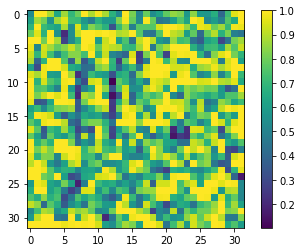

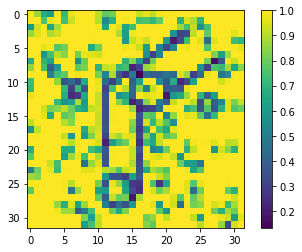

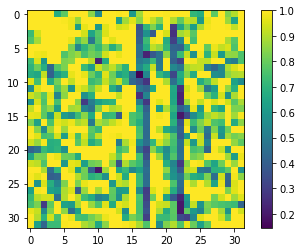

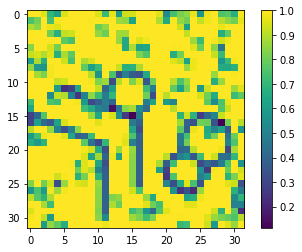

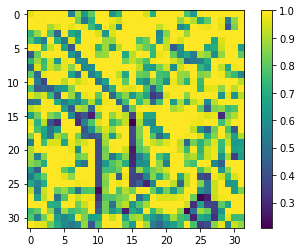

In [11]:
for i in range (0, 5) :
    plt.figure()
    plt.imshow(train_images[i].reshape((size_th, size_th)))   # train_images[0])
    plt.colorbar()
    plt.grid(False)

In [12]:
# myimages[0]

In [13]:
train_labels[:100]

array([1, 4, 3, 0, 0, 3, 4, 3, 3, 0, 1, 1, 0, 4, 3, 4, 1, 1, 4, 4, 2, 0,
       2, 3, 1, 3, 2, 4, 2, 2, 4, 1, 2, 4, 4, 0, 3, 3, 4, 4, 1, 0, 2, 4,
       3, 0, 4, 4, 1, 4, 4, 0, 1, 4, 0, 2, 2, 4, 1, 2, 0, 3, 3, 1, 3, 3,
       0, 3, 1, 2, 0, 4, 0, 2, 1, 1, 0, 2, 2, 4, 3, 0, 4, 2, 0, 3, 1, 2,
       4, 3, 2, 1, 0, 2, 1, 2, 2, 3, 1, 4])

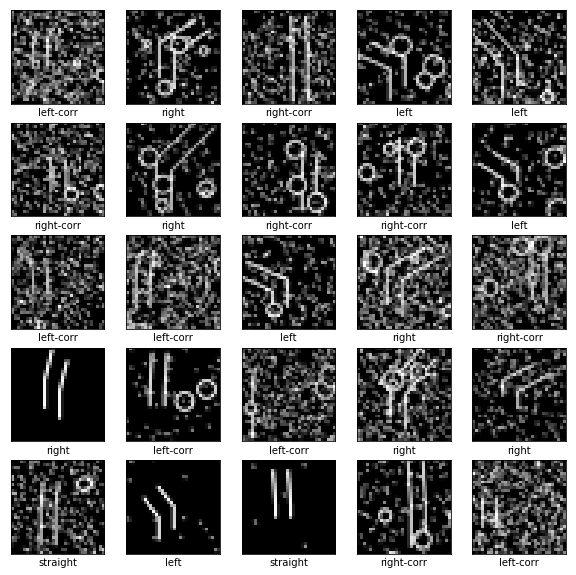

In [14]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].reshape((size_th, size_th)), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

In [15]:
# model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(size_th, size_th), name='Flattener'),
#     keras.layers.Dense(128, activation=tf.nn.relu, name='Dense_Relu'),
#     keras.layers.Dropout(0.1, noise_shape=None, seed=None, name='Dropper'),
#     keras.layers.Dense(10, activation=tf.nn.softmax, name='Dense_Softmax')
# ])

In [16]:
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(size_th, size_th, 1), name='Conv2D_first'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='Pooler_first'),
    keras.layers.Dropout(0.1, noise_shape=None, seed=None, name='Dropper_one'),
    keras.layers.Conv2D(64, (5, 5), activation='relu', name='Conv2D_second'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), name='Pooler_second'),
    keras.layers.Dropout(0.1, noise_shape=None, seed=None, name='Dropper_two'),
    keras.layers.Flatten(name='Flattener'),
    keras.layers.Dense(1000, activation='relu', name='Dense_Relu'),
    keras.layers.Dense(num_classes, activation='softmax', name='Dense_Softmax')
])

In [17]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
# in the environment terminal, run:
#     tensorboard --logdir Documents/TensorFlowDriving/logs/1
# point the browser here:
#     http://localhost:6006

ts = datetime.now().strftime("%Y-%m-%d_%H.%M.%S")
log_path = "logs/1/" + ts + "_-_" + run_tag # + model.name 

tensorboard = TensorBoard(log_path, histogram_freq=1, write_graph=True, write_grads=True, write_images=True)

# docs:  https://keras.io/callbacks/#tensorboard
# logs in C:\Users\sergei\Documents\TensorFlowDriving\logs\1

In [19]:
model.fit(train_images, train_labels, 
          epochs=EPOCHS, 
          validation_data=(val_images, val_labels),
          verbose=1, callbacks=[tensorboard])

Train on 10000 samples, validate on 1000 samples
Epoch 1/3
10000/10000 [==============================] - 34s 3ms/step - loss: 0.3858 - acc: 0.8474 - val_loss: 0.0430 - val_acc: 0.9830
Epoch 2/3
10000/10000 [==============================] - 35s 3ms/step - loss: 0.0593 - acc: 0.9809 - val_loss: 0.0252 - val_acc: 0.9900
Epoch 3/3
10000/10000 [==============================] - 35s 3ms/step - loss: 0.0357 - acc: 0.9887 - val_loss: 0.0291 - val_acc: 0.9900


In [20]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

1000/1000 [==============================] - 1s 733us/step
Test accuracy: 0.992


In [21]:
predictions = model.predict(test_images)

In [22]:
predictions[0]

array([2.3892213e-02, 9.7602534e-01, 6.6775436e-05, 7.3732303e-07,
       1.4935819e-05], dtype=float32)

In [23]:
# tf.summary.histogram("predictions", predictions)

In [24]:
np.argmax(predictions[0])

1

In [25]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img.reshape((size_th, size_th)), cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(num_classes), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

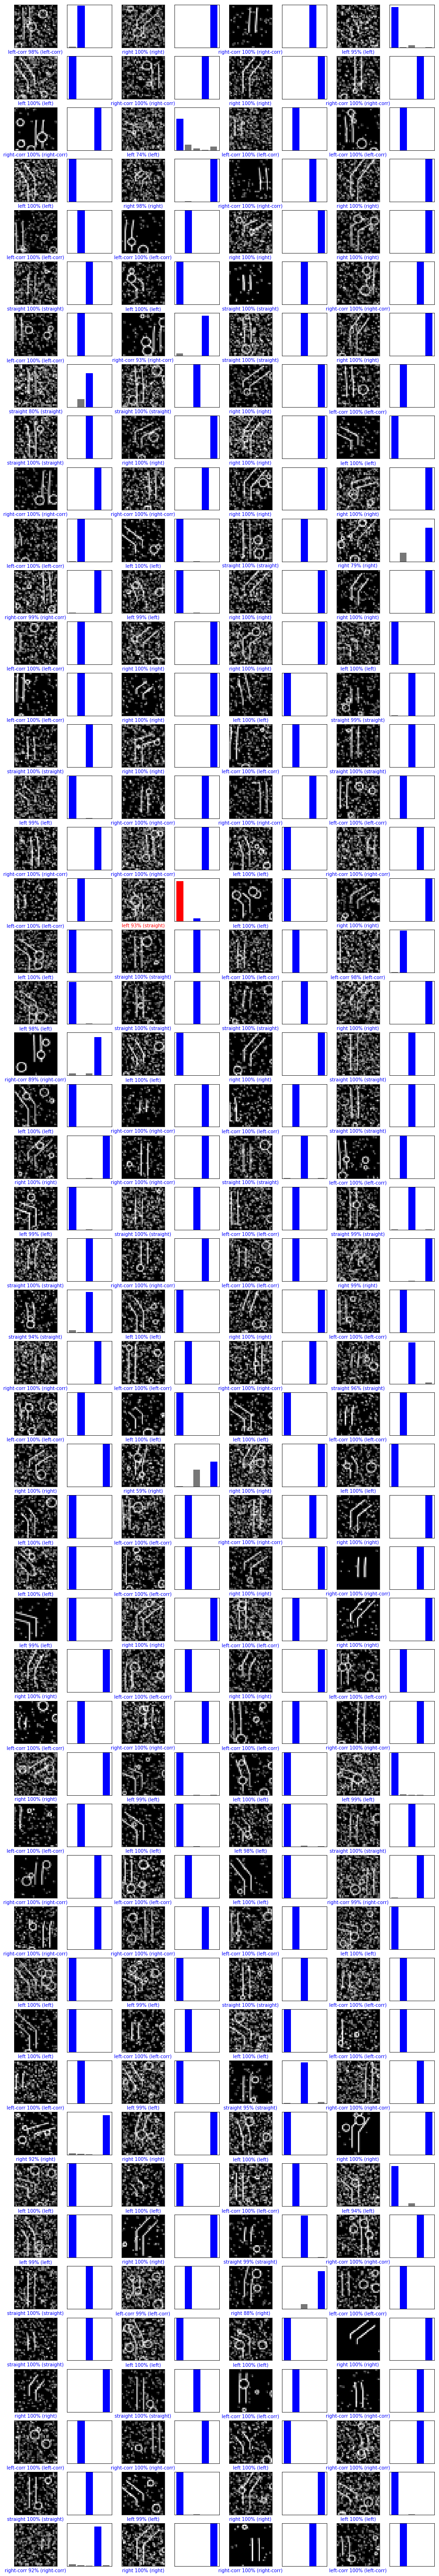

In [26]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 50
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)